In [72]:
import numpy as np
import pandas as pd
import os
import pickle
import joblib
import sys
import glob
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.signal import correlate
import seaborn as sea
%config InlineBackend.figure_format = 'retina'

In [64]:
abnormal_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver'
normal_path = '/net/adv_spectrum/data/rss/downsample_10/normal/ryerson_ab_train'

In [65]:
def rss_autocorr(path, step=1000):
    all_corrs = []
    for file in glob.glob(path + '/*.txt'):
        rss = []
        with open(file, 'r') as f:
            for line in f:
                x = line.split()
                rss.append(float(x[0]))
        rss = np.array(rss).reshape(-1)[:156000]
        corrs = []
        for i in range(step, len(rss), step):
            corr = pearsonr(rss[i - step:i], rss_normal[i:i + step])[0]
            corrs.append(corr)
        all_corrs.extend(corrs)
    return all_corrs


def rss_mean(path, step=1000):
    all_means = []
    for file in glob.glob(path + '/*.txt'):
        rss = []
        with open(file, 'r') as f:
            for line in f:
                x = line.split()
                rss.append(float(x[0]))
        rss = np.array(rss).reshape(-1)[:156000]
        means = []
        for i in range(step, len(rss), step):
            mean = np.mean(rss[i - 1000:i])
            means.append(mean)
        all_means.extend(means)
    return all_means

In [66]:
normal_all_corrs = rss_autocorr(normal_path, step=1000)
abnormal_all_corrs = rss_autocorr(abnormal_path, step=1000)
normal_all_means = rss_mean(normal_path, step=1000)
abnormal_all_means = rss_mean(abnormal_path, step=1000)

In [89]:
df = pd.DataFrame()

In [94]:
normal_label = np.zeros(len(normal_all_means))
abnormal_label = np.ones(len(abnormal_all_means))

In [95]:
all_means = np.concatenate((normal_all_means, abnormal_all_means))
all_corrs = np.concatenate((normal_all_corrs, abnormal_all_corrs))
all_label = np.concatenate((normal_label, abnormal_label))

In [98]:
df['power'] = all_means
df['autocorrelation'] = all_corrs
df['label'] = all_label
df.label = df.label.astype('int32')

In [100]:
df.head()

,power,autocorrelation,label
0,-41.162957,0.096463,0
1,-41.385498,0.116233,0
2,-41.269331,0.046087,0
3,-41.388522,-0.042631,0
4,-41.198471,0.042376,0


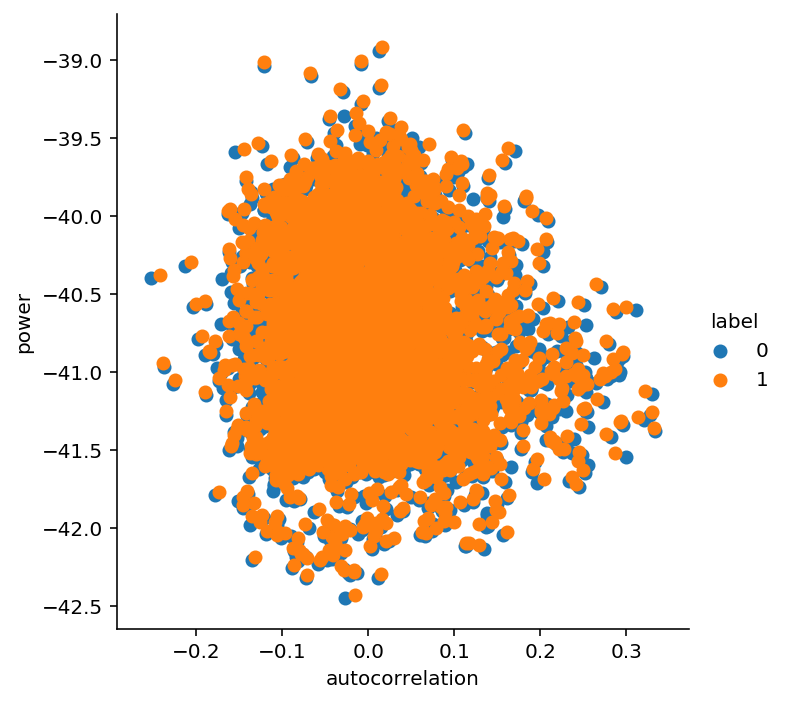

In [104]:
g = sea.lmplot(x='autocorrelation', y='power', 
               data=df, hue='label', fit_reg=False, scatter_kws={'alpha':1})

In [ ]:
def plot_2d_rss(sample_num, window_size):
    normal_corrs = corr_array(X_normal, sample_num, window_size)
    fbs_corrs = corr_array(X_fbs, sample_num, window_size)
    cso_corrs = corr_array(X_cso, sample_num, window_size)
    jamming_corrs = corr_array(X_jamming, sample_num, window_size)

    normal_means = avg_rss(X_normal, sample_num, window_size)
    fbs_means = avg_rss(X_fbs, sample_num, window_size)
    cso_means = avg_rss(X_cso, sample_num, window_size)
    jamming_means = avg_rss(X_jamming, sample_num, window_size)

    X = np.concatenate((normal_means, jamming_means, fbs_means, cso_means))
    X_corrs = np.concatenate((normal_corrs, jamming_corrs , fbs_corrs, cso_corrs))
    y = np.concatenate((['Normal']*sample_num, ['FBS']*sample_num, 
                        ['CSO']*sample_num, ['Jamming']*sample_num))

    df_rss_corr = pd.DataFrame(X, columns=['RSS'])
    df_rss_corr['corr'] = X_corrs
    df_rss_corr['Type'] = y

    portion = 1200 / sample_num 

    df_sample = df_rss_corr.sample(frac=portion, replace=True, random_state=1)
    markers=['.', '+', '1', '2']
    sns.set_style("white", {'axes.linewidth': 5, 'axes.edgecolor':'black'})
    g = sns.lmplot(x='corr', y='RSS', markers = markers, 
               data=df_sample, hue='Type', fit_reg=False, scatter_kws={'alpha':1})
    sns.despine(top=False, right=False)
    plt.setp(g._legend.get_texts(), fontsize=12)
    plt.title('Auto-Corr Step = '+ str(window_size))
    plt.show()